In [1]:
import pandas as pd

In [2]:
# Load dataset
df = pd.read_csv("D:/WORKSPACE_CS/LJMU_Research/other/dash/health_policy_recomendation/src/health_policy_recomendation/data/ushealthinsurance.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
import random

# Version 3: Attempting to increase importance of sex and region
def assign_company_complex(row):
     # --- Company A: High Risk Focus ---
     # Added a rule specifically for younger male smokers
     if row['smoker'] == 'yes':
          if row['bmi'] > 32 or row['age'] > 55:
               return 'Company A'
          # NEW RULE A1: Target younger male smokers explicitly
          elif row['sex'] == 'male' and row['age'] < 40:
               # Give younger male smokers a direct path to A
               return 'Company A'
     elif row['bmi'] > 40: # High BMI check (largely unchanged)
          return 'Company A'

     # --- Company B: Established / Family Focused / Regional ---
     # Original rule using NW/SW region remains
     elif row['smoker'] == 'no' and row['children'] >= 2:
          if (row['region'] in ['northwest', 'southwest']) and (35 <= row['age'] <= 60):
               return 'Company B'
          # Modified the "any region" rule slightly - perhaps make it female-biased?
          elif row['bmi'] < 30 and row['age'] < 50 and row['sex'] == 'female': # MODIFIED: Added sex condition
               return 'Company B'

     # --- Company C: Younger / Health-Conscious / Individual ---
     # Added a region-specific rule (Northeast)
     elif row['smoker'] == 'no' and row['age'] < 35:
          # NEW RULE C1: Region NE focus for young individuals without children
          if row['region'] == 'northeast' and row['children'] == 0:
               return 'Company C'
          # Rule C2 (Original v2 Rule C1 - Relaxed BMI/children)
          elif row['children'] <= 1 and row['bmi'] < 27:
               return 'Company C'
          # Rule C3 (Original v2 Rule C2 - Female bias - unchanged)
          elif row['children'] <= 1 and row['bmi'] < 28 and row['sex'] == 'female':
               return 'Company C'

     # --- Company D: Older / Lower-Risk Individuals / Other ---
     # Added region (SE) and sex (female) specific conditions
     elif row['smoker'] == 'no' and row['age'] > 62:
          # Rule D1a: Added explicit female condition for older group
          if row['bmi'] < 33 and row['sex'] == 'female':
               return 'Company D'
          # Rule D1b: Original rule now mainly applies to males or those failing D1a
          elif row['bmi'] < 33:
               return 'Company D'
     # NEW RULE D2: Region SE focus for middle-aged/older non-smokers
     elif row['smoker'] == 'no' and row['region'] == 'southeast' and row['age'] >= 40:
          return 'Company D'
     # Rule D3: Original male-focused rule (unchanged)
     elif row['smoker'] == 'no' and row['sex'] == 'male' and row['children'] <= 1 and row['age'] >= 35:
          return 'Company D'

     # --- Fallback ---
     # Assigns remaining profiles to D.
     else:
          return 'Company D'

# # --- Function to add noise (use the same one as before) ---
# def assign_company_with_noise(row, noise_level=0.10):
#     base_company = assign_company_complex(row)
#     if random.random() < noise_level:
#         all_companies = ['Company A', 'Company B', 'Company C', 'Company D']
#         other_companies = [c for c in all_companies if c != base_company]
#         if other_companies:
#              return random.choice(other_companies)
#         else:
#              return base_company
#     else:
#         return base_company
    

# def assign_company_with_noise(row, noise_level=0.10):
#     try:
#         base_company = assign_company_complex(row)
#         if random.random() < noise_level:
#             all_companies = ['Company A', 'Company B', 'Company C', 'Company D']
#             other_companies = [c for c in all_companies if c != base_company]
#             return random.choice(other_companies)
#         else:
#             return base_company
#     except Exception as e:
#         print(f"Error at row:\n{row}\nException: {e}")
#         return None

def assign_company_with_noise(row, noise_level=0.1):
    try:
        base_company = assign_company_complex(row)
        if random.random() < noise_level:
            all_companies = ['Company A', 'Company B', 'Company C', 'Company D']
            other_companies = [c for c in all_companies if c != base_company]
            return random.choice(other_companies)
        else:
            return base_company    
    except Exception as e:
        print(f"Error processing row:\n{row}\nException: {e}")
        return 'Company D'  # or return None if you want to track failures

df['insurance_company'] = df.apply(assign_company_with_noise, axis=1)

In [ ]:
df.info()

In [ ]:
df_null = df[df['insurance_company'].isna()]
df_null.head()

## Using all features as is 

In [3]:
# approach 2 of creating company using natural clustering

from sklearn.cluster import KMeans

# Prepare features
features = df.copy()
# Encode categorical features
X_cluster = pd.get_dummies(features, columns=['sex', 'smoker', 'region'], drop_first=True)

# Find optimal clusters
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster)

# Map clusters to companies
cluster_to_company = {
    0: 'Company A',
    1: 'Company B',
    2: 'Company C',
    3: 'Company D'
}
df['insurance_company'] = df['cluster'].map(cluster_to_company)

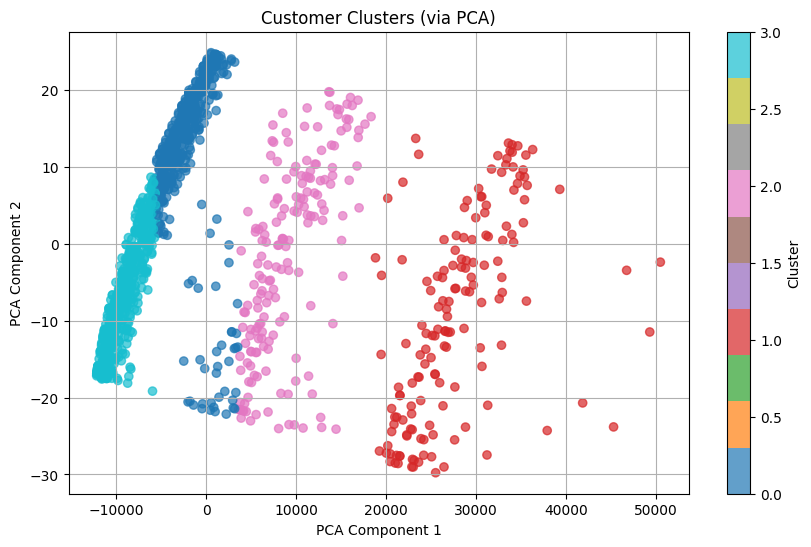

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_cluster)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['cluster'], cmap='tab10', alpha=0.7)
plt.title('Customer Clusters (via PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [5]:
df['insurance_company'].value_counts(normalize=True)

insurance_company
Company D    0.415546
Company A    0.336323
Company C    0.132287
Company B    0.115845
Name: proportion, dtype: float64

In [ ]:
df.drop(columns=['cluster'], inplace=True)

In [ ]:
df.columns

In [ ]:
df.to_csv(r'D:/WORKSPACE_CS/LJMU_Research/other/dash/health_policy_recomendation/src/health_policy_recomendation/data/ushealthinsurance_with_company3.csv', index=False)

## Dropping `charges` column

In [7]:
# Load dataset
df = pd.read_csv("D:/WORKSPACE_CS/LJMU_Research/other/dash/health_policy_recomendation/src/health_policy_recomendation/data/ushealthinsurance.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
# approach 2 of creating company using natural clustering

from sklearn.cluster import KMeans

# Prepare features
features = df.drop(columns=['charges'])
# Encode categorical features
X_cluster = pd.get_dummies(features, columns=['sex', 'smoker', 'region'], drop_first=True)

# Find optimal clusters
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster)

# Map clusters to companies
cluster_to_company = {
    0: 'Company A',
    1: 'Company B',
    2: 'Company C',
    3: 'Company D'
}
df['insurance_company'] = df['cluster'].map(cluster_to_company)

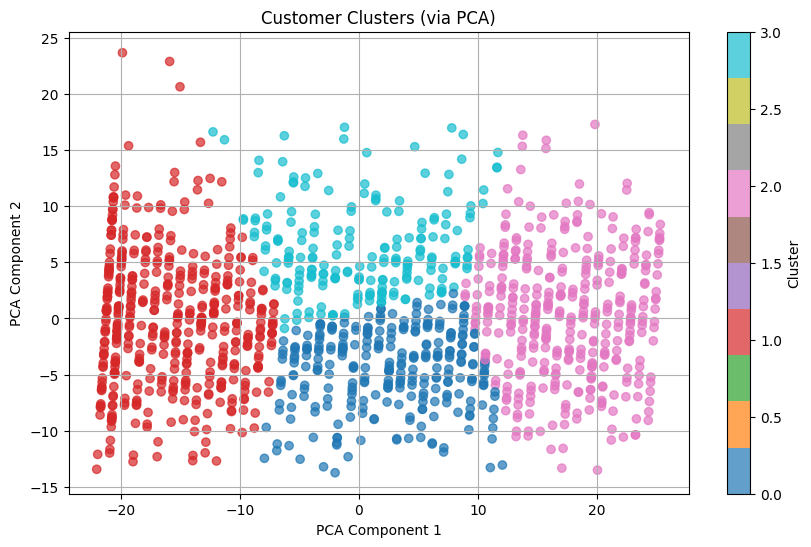

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_cluster)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['cluster'], cmap='tab10', alpha=0.7)
plt.title('Customer Clusters (via PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [10]:
df['insurance_company'].value_counts(normalize=True)

insurance_company
Company B    0.350523
Company C    0.283259
Company A    0.213004
Company D    0.153214
Name: proportion, dtype: float64

## Dropping `charges` but adding a derived column called `budget`

In [11]:
# Load dataset
df = pd.read_csv("D:/WORKSPACE_CS/LJMU_Research/other/dash/health_policy_recomendation/src/health_policy_recomendation/data/ushealthinsurance.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [12]:
q1 = df['charges'].quantile(0.25)
q3 = df['charges'].quantile(0.75)

df['budget'] = pd.cut(
    df['charges'],
    bins=[-float('inf'), q1, q3, float('inf')],
    labels=['Low', 'Medium', 'High']
)

In [13]:
# approach 2 of creating company using natural clustering

from sklearn.cluster import KMeans

# Prepare features
features = df.drop(columns=['charges'])
# Encode categorical features
X_cluster = pd.get_dummies(features, columns=['sex', 'smoker', 'region', 'budget'], drop_first=True)

# Find optimal clusters
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster)

# Map clusters to companies
cluster_to_company = {
    0: 'Company A',
    1: 'Company B',
    2: 'Company C',
    3: 'Company D'
}
df['insurance_company'] = df['cluster'].map(cluster_to_company)

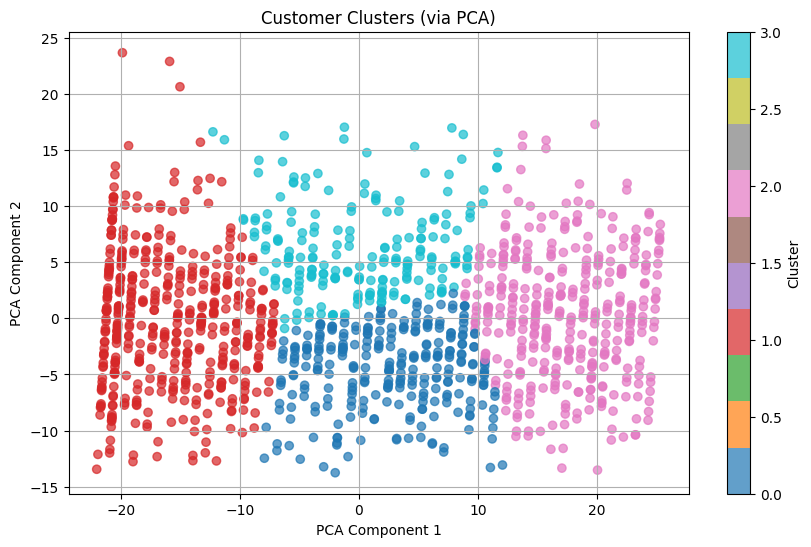

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_cluster)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['cluster'], cmap='tab10', alpha=0.7)
plt.title('Customer Clusters (via PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [15]:
df['insurance_company'].value_counts(normalize=True)

insurance_company
Company B    0.350523
Company C    0.283259
Company A    0.213004
Company D    0.153214
Name: proportion, dtype: float64